# Elements de correction

## Question de cours
### Question a) Cycle de base d'exécution des instructions assembleur

Par exemple :

* Lecture de l'instruction
* Décodage & Exécution
* Passage à l'instruction suivante

(on peut aussi détailler ces étapes et/ou ajouter la gestions des paramètres et des résultats)

### Question b&c) Pipe-Line

Il s'agit de l'exécution en même temps de plusieurs instructions, chacune à un moment différent du cycle :

* l'une finit son cycle avec le calcul de l'adresse de l'instruction suivante
* une seconde est au milieu de son cycle
* une troisième commence son cycle avec la lecture de l'instruction

Gain visé :

* effectuer N instruction pour aller N fois plus vite (N=Nombre d'étape dans le cycle)

Contraintes :

* Matérielles : que le circuit puisse réaliser en parallèle les différentes étapes du cycle
* Fonctionnelles : qu'il n'y ait pas de dépendances entre les instructions (ni vis à vis des données, ni vis à vis du choix de l'instruction suivante)


Pour en savoir plus : 

* [https://fr.wikipedia.org/wiki/Pipeline_(architecture_des_processeurs)](https://fr.wikipedia.org/wiki/Pipeline_(architecture_des_processeurs))

## Programmation ARM

L'exercice porte sur la traduction du calcul de la distance d'édition entre 2 chaînes de caractères.

Un début de programme est donné (complété un peu ici pour permettre des tests) :

In [1]:
%%writefile progTBC.s
#ifndef _INIT_D
#define _INIT_D 42
#endif
#ifndef _CONTROLE_CH1
#define _CONTROLE_CH1
#endif
#ifndef _CONTROLE_CH2
#define _CONTROLE_CH2
#endif
.data
msg1: .asciz "Entrer un mot"
msg2: .asciz "Distance entre les 2 mots "
d: .word _INIT_D
.bss
ch1: .skip 80
ch2: .skip 80
.text
.global main
main: push {lr}
    
    @@ A COMPLETER
#include "corpsMain.s"

    pop {lr}
    mov R0, #0
    bx lr
#ifdef FONCTION
#include "fonction.s"
#else
DistLev:
    bx lr
#endif
LD_d: .word d
LD_ch1: .word ch1
LD_ch2: .word ch2
LD_msg1: .word msg1
LD_msg2: .word msg2

Overwriting progTBC.s


### Question d) Traduction des entrées-sorties
 
La traduction du programme principal (hors appel à la fonction) :

In [2]:
%%writefile corpsMain.s
@20: EcrChaine("Entrer un mot")
    ldr R1, LD_msg1              @ Qestion d)
    bl EcrChaine                 @ Qestion d)
@21: LireChaine(&ch1)
    ldr R1, LD_ch1               @ Qestion d)
    bl LireChaine                @ Qestion d)
    _CONTROLE_CH1
@22: EcrChaine("Entrer un mot")
    ldr R1, LD_msg1              
    bl EcrChaine
@23: LireChaine(&ch2)
    ldr R1, LD_ch2
    bl LireChaine
    _CONTROLE_CH2
@24: d:=DistLev(ch1,ch2)
#ifdef APPEL
#include "appel.s"
#endif
@25: EcrChaine("Distance entre les 2 mots ")
    ldr R1, LD_msg2              @ Qestion d)
    bl EcrChaine                 @ Qestion d)
@26: EcrNdecimal32(d)
    ldr R1, LD_d                 @ Qestion d)
    ldr R1, [R1]                 @ Qestion d)
    bl EcrNdecimal32             @ Qestion d)

Overwriting corpsMain.s


<a id="RetourAnnexe1"></a>
Pour tester (un peu) :

In [3]:
!cpp progTBC.s  > prog.s
!arm-linux-gnueabi-gcc -static prog.s es.s -o prog.e
!printf 'INM\nMIN\n' | qemu-arm  prog.e

Entrer un mot
Entrer un mot
Distance entre les 2 mots 
42


La réponse (42) est la valeur initiale mise par défaut pour d. (rem. : Cette valeur initiale peut être modifiée sur la ligne de commande de la prè-compilation \[cpp -D _INIT_D=<valeur initiale de d>\])

*Pour tester plus, il faudrait, par exemple, faire varier la valeur initiale de d et ajouter un affichage de contrôle des chaînes ch1 et ch2 (cf. [Annexe 1](#Annexe1))*

### Question e) Appel de fonction

In [4]:
%%writefile appel.s
@d:=DistLev(ch1,ch2)             @ Qestion e)
    ldr R0, LD_ch1
    push {R0}
    ldr R0, LD_ch2
    push {R0}
    sub SP, SP, #4
    bl DistLev
    pop {R0}
    add SP, SP, #8
    ldr R1, LD_d
    str R0, [R1]

Overwriting appel.s


<a id="RetourAnnexe2"></a>
Pour tester (un peu) :

In [5]:
!cpp -D APPEL progTBC.s > prog.s
!arm-linux-gnueabi-gcc -static prog.s es.s -o prog.e
!printf "INM\nMIN\n" | qemu-arm  prog.e

Entrer un mot
Entrer un mot
Distance entre les 2 mots 
1082132356


La réponse (un nombre presque aléatoire) corespond à ce qui était en mémoire là où on a réservé de la place pour le résultat sur la pile, ce n'est pas complètement aléatoire (il y a bien eu un moment où cette valeur signifiait quelque chose pour le programme qui l'employait) mais elle n'est pas liée à ce que l'on veut faire.

*Pour tester plus, il faudrait, par exemple, ajouter une action visible dans la fonction DistLev (comme, empiler une valeur connue au niveau du résultat, au lieu de simplement réserver de la place, cf. [Annexe 2](#Annexe2))*

### Question f) et i) Prologue, retour et épilogue de la fonction

In [6]:
%%writefile fonction.s
DistLev:
    push {lr}                   @ Qestion f) 
    push {fp}
    mov fp,sp
    sub sp,sp,#8
    push {R0}
    push {R1}
    push {R2}
#ifdef CORPS
#include "corpsFonction.s"
#endif
    ldr R0, [fp,#-4]            @ Qestion i)
    str R0, [fp,#8]
    pop {R2}
    pop {R1}
    pop {R0}
    add sp,sp,#8
    pop {fp}
    pop {lr}
    bx lr

Overwriting fonction.s


Pour tester (un peu) :

In [7]:
!cpp  -D APPEL -D FONCTION progTBC.s > prog.s
!arm-linux-gnueabi-gcc -static prog.s es.s -o prog.e
!printf "INM\nMIN\n" | qemu-arm  prog.e

Entrer un mot
Entrer un mot
Distance entre les 2 mots 
1082132684


*Pour tester plus, il faudrait, par exemple, ajouter une action visible dans le corps de la fonction DistLev, c'est l'objet de la suite.*

Pour la suite, un dessin permet de mieux comprendre l'organisation de la pile :
```
       | ... |
       | R2  |
       | R1  |  
       | R0  |
       | alt |  
       | loc |
 fp -> | fp  |  
       | lr  |
       | res |  
       | ch2 |
       | ch1 |  
       | ... |
```

### Question g) Conditionnelle

In [8]:
%%writefile corpsFonction.s
@si (a[0]+b[0]) == 0 alors loc = 0 sinon l.2 finsi(l.11)  @ Qestion g)
    ldr R0, [fp,#16]
    ldrb R0, [R0]
    ldr R1, [fp,#12]
    ldrb R1, [R1]
    add R0, R0, R1
    cmp R0, #0
    bne l.2
    str R0, [fp,#-4]
    b l.11
l.2: nop
#ifdef ALT
#include "alt.s"
#endif
l.11: nop

Overwriting corpsFonction.s


Pour tester (un peu) :

In [9]:
!cpp  -D APPEL -D FONCTION -D CORPS progTBC.s > prog.s
!arm-linux-gnueabi-gcc -static prog.s es.s -o prog.e
!printf "\n\n" | qemu-arm  prog.e

Entrer un mot
Entrer un mot
Distance entre les 2 mots 
0


Pour 2 textes vides, le programme donne bien une distance de 0 (sans appel récursif imbriqué)

*Pour tester un peu plus, il faudrait aussi vérifier avec 2 mots non vides*

### Question h) appel récursif imbriqué

In [10]:
%%writefile alt.s
@alt = 1 + DistLev(a, adresse de b[1])     @ Qestion h)
    ldr R0, [fp,#16]
    push {R0}
    ldr R0, [fp,#12]
    add R0,R0,#1
    push {R0}
    sub SP, SP, #4
    bl DistLev
    pop {R0}
    add SP, SP, #8
    add R0,R0,#1
    str R0, [fp,#-8]

Overwriting alt.s


<a id="RetourAnnexe3"></a>
Pour tester (un peu) :

In [11]:
!cpp  -D APPEL -D FONCTION -D CORPS -D ALT progTBC.s > prog.s
!arm-linux-gnueabi-gcc -static prog.s es.s -o prog.e
!printf "\nMIN\n" | qemu-arm  prog.e

Entrer un mot
Entrer un mot
Distance entre les 2 mots 
1082132684


Ca donne un résultat imprévisible, parceque le code modifie ```alt``` et non pas ```loc```.

*Pour tester plus, il faudrait, par exemple, prendre un cas qui repose seulement sur les cas présents (vide/vide et \*/vide), par exemple le cas où l'un des textes est vide et où on épuise l'autre seulement et, de plus, que les calculs se fassent sur ```loc``` plutôt que sur ```alt```, cf. [Annexe 3](#Annexe3))*



### Fin de l'exercice

L'exercice est terminé, les tests passent. Pour avoir l'ensemble de la fonction, il faudrait compléter le corps. Cela permettrait de valider un peu plus le programme en entier (cf. [Annexe 5](#Annexe5)) et voir l'ensemble du code (cf. [Annexe 6](#Annexe6))

Remarques sur la rédaction de cette correction :  

* une première rédaction papier (avec dessin, car c'est facile d'ajouter des dessins dans ce cas) : 
  * avait permis de voir une erreur de sujet (oubli de la fonction LireChaine dans les annexes du sujet)
  * comportait une erreur d'inattention (mis R1 au lieu de R0, dans un contexte où il n'y avait pas de R1 !)
* la rédaction sur jupyter (sans dessin, car cela semble difficile de faire des dessins en ascii \[en fait, ce n'est pas vrai, on peut faire des dessins simples en ascii, cf. plus haut\])
  * a été plus difficile pour déterminer les adresses dans la pile (j'aurais dû faire un dessin plus tôt ; il a été introduit à la fin seulement, pour faire joli, il aurait dû être mis dès le départ, pour faciliter l'écriture !)
  * comportait deux erreurs de copier-coller, hors des questions de l'examen (saisie de ch1 deux fois, au lieu de saisie de ch1 puis ch2, un +1 de trop l.4 du code initial, c'est la seule ligne où il n'y a pas +1 !)
  * comportait une erreur d'écriture de la variable alt dans la pile (confusion entre alt et @alt)
  * comportait une inversion ch1/ch2 (sans conséquence)
* conclusion : le papier et les dessins, c'est bien ; mais avec jupyter, si l'on fait les dessins et les tests, c'est encore mieux car les erreurs sont découvertes/corrigées à l'exécution lors des tests et on vérifie effectivement que c'est vraiment ok.

## Automate d'interprétation et processeur

### Question j) Image mémoire
  

 @  | Mem | Commentaire
----|-----|--------------
 0  |  2  |  ld
 1  |  1  |
 2  |  5  |  add
 3  |  E  |
 4  |  5  |  add
 5  |  F  |
 6  |  3  |  st
 7  |  F  |
 8  |  4  |  jmp
 9  |  4  |
 A  |  ?  |  
 B  |  ?  |
 C  |  ?  |
 D  |  ?  |
 E  |  4  |  var A
 F  |  9  |  var B
 
### Question k) Simulation ASM

L'accumulateur prend les valeurs suivantes : 1, 5, 14 (=-2 sur 4 bits), 12 (=-4), 8 (=-8) puis 0.

### Question l) Simulation Automate

Les états et micro-actions :

* pc <- 0
* ma <- pc
* md <- Mem[ma]
* ri <- md
* pc <- pc+1
* ma <- pc
* pc <_ pc+s
* md <- Mem[ma]
* acc <- md     @ fin de ld
* ma <- pc
* md <- Mem[ma]
* ri <- md
* pc <- pc+1
* ma <- pc
* pc <_ pc+s
* md <- Mem[ma]
* ma <- md
* md <- Mem[ma]
* acc <- acc + md @ fin de add
* ...

### Question m) Ajout d'instructions

<a id="RetourAnnexe4"></a>
Automate avec ajout :  
*(automate de contrôle initial en [annexe 4](#Annexe4))*

![automate avec ajout](./graphSolution.png)

# Commentaires

Moyenne des copies à 9.3, écart-type à 4.5, max à 20 (bravo).

In [12]:
%%writefile histogramme.r
notes <- c(rep(1, 10), rep(2, 12), rep(3, 10), rep(4, 9), rep(5, 7), rep(6, 16), rep(7, 10), rep(8, 21),rep(9, 14),rep(10, 23),rep(11, 19),rep(12, 15),rep(13, 12),rep(14, 16),rep(15, 8),rep(16, 11),rep(17, 5),rep(18, 3),rep(19, 3),rep(20, 1))
png(file = "histogramme.png", width = 800, height = 700)
plot(hist(notes, breaks=seq(0.5, 20.5, by=1), xlab="Notes", ylab="Fréquence", main="Histogramme des notes"))
dev.off()

Overwriting histogramme.r


null device 
          1 


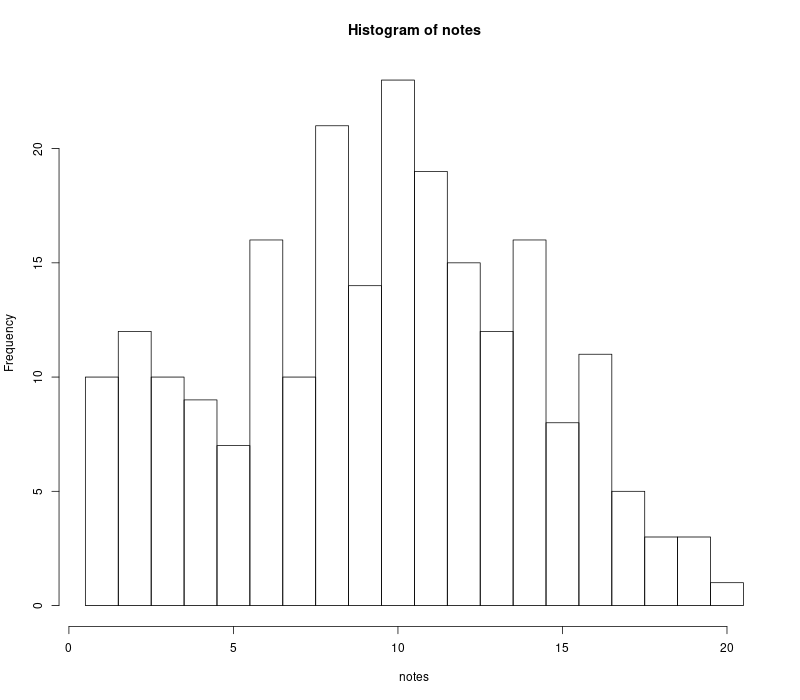

In [13]:
from PIL import Image
from IPython.display import display
!Rscript histogramme.r
img = Image.open('histogramme.png')
display(img)

Erreurs :  

* Exercice 1 : très peu répondu, et souvent mal répondu (l'architecture de von Neumann n'était pas la réponse attendue), 1/3 des copies (seulement) a 1 point à la question a), pour les questions 2) et 3) c'est un peu moins encore (1/4 des copies)
* Exercice 2 : assez bien répondu (par ex. 2/3 des questions d) bien répondues même s'il reste des erreurs (cf. [annexe 7](#Annexe7))),  cependant, il y a de nombreuses erreurs liées à la taille des caractères (1 seul octet, donc qestion d, ldr**b** et add ..., **#1**, (cf. [annexe 8](#Annexe8)))

N.B. : Matrice des questions, en fonction des domaines et des (niveaux de) compétences sollicités.

|            | Binaire | Arm-AlgoElem | Arm-Fun | Archi |
|------------|---------|--------------|---------|-------|
| Connaitre  |         |              | Q-f,i   | Q-a,b,c |
| Comprendre | Q-j,k,l |              |         |       |
| Appliquer  |         |  Q-d,g,h     | Q-e     |       |
| Maitriser  |         |              |         | Q-m   |

rem . : la matrice du partiel remplissait les colonnes Binaire (Connaitre, Appliquer et Maitriser), Arm-AlgoElem (Connaitre, Appliquer)

## Annexes



<a id="Annexe1"></a>

### Annexe 1 [&uarr;](#RetourAnnexe1)


In [14]:
!cpp -D _INIT_D=2048 progTBC.s > prog.s
!arm-linux-gnueabi-gcc -static prog.s es.s -o prog.e
!printf 'INM\nMIN\n' | qemu-arm  prog.e

Entrer un mot
Entrer un mot
Distance entre les 2 mots 
2048


In [15]:
!cpp -D '_CONTROLE_CH1=£ldr R1, LD_ch1£bl EcrChaine£' -D '_CONTROLE_CH2=£ldr R1, LD_ch2£bl EcrChaine£' progTBC.s | tr '£' '\n' > prog.s
!arm-linux-gnueabi-gcc -static prog.s es.s -o prog.e
!printf 'INM\nMIN\n' | qemu-arm  prog.e

Entrer un mot
INM
Entrer un mot
MIN
Distance entre les 2 mots 
42


<a id="Annexe2"></a>

### Annexe 2 [&uarr;](#RetourAnnexe2)


In [16]:
%%writefile appel.s
@d:=DistLev(ch1,ch2)
    ldr R0, LD_ch1
    push {R0}
    ldr R0, LD_ch2
    push {R0}
    mov R0, #1024
    push {R0}
    bl DistLev
    pop {R0}
    add SP, SP, #8
    ldr R1, LD_d
    str R0, [R1]

Overwriting appel.s


In [17]:
!cpp -D APPEL progTBC.s > prog.s
!arm-linux-gnueabi-gcc -static prog.s es.s -o prog.e
!printf "INM\nMIN\n" | qemu-arm  prog.e

Entrer un mot
Entrer un mot
Distance entre les 2 mots 
1024


Pour la suite, vous pouvez reprendre la première définition de ```appel.s``` ([plus haut](#RetourAnnexe2)) ou garder celle-ci (un peu plus longue).

<a id="Annexe3"></a>

### Annexe 3 [&uarr;](#RetourAnnexe3)


In [18]:
%%writefile alt.s
@alt = 1 + DistLev(a, adresse de b[1]) ==>> loc = 1 + DistLev(a, adresse de b[1]) 
    ldr R0, [fp,#16]
    push {R0}
    ldr R0, [fp,#12]
    add R0,R0,#1 
    push {R0}
    sub SP, SP, #4
    bl DistLev
    pop {R0}
    add SP, SP, #8
    add R0,R0,#1
    str R0, [fp,#-4] @@ loc au lieu de alt

Overwriting alt.s


In [19]:
!cpp  -D APPEL -D FONCTION -D CORPS -D ALT progTBC.s > prog.s
!arm-linux-gnueabi-gcc -static prog.s es.s -o prog.e
!printf "\nMIN\n" | qemu-arm  prog.e

Entrer un mot
Entrer un mot
Distance entre les 2 mots 
3


Attention, pour la suite, reprendre la bonne définition de ```alt.s``` (cf. [plus haut](#RetourAnnexe3) ou ci-dessous).

In [20]:
%%writefile alt.s
@alt = 1 + DistLev(a, adresse de b[1]) 
    ldr R0, [fp,#16]
    push {R0}
    ldr R0, [fp,#12]
    add R0,R0,#1 
    push {R0}
    sub SP, SP, #4
    bl DistLev
    pop {R0}
    add SP, SP, #8
    add R0,R0,#1
    str R0, [fp,#-8] 

Overwriting alt.s


<a id="Annexe4"></a>

### Annexe 4 [&uarr;](#RetourAnnexe4) 


In [21]:
%%writefile graphInit.dot
digraph { 
    init -> fetch;
    fetch -> arg [label = "*"];
    arg -> ld [label = "ld"];
    arg -> jmp [label = "jmp"];
    arg -> arg2 [label = "*"];
    arg2 -> st [label = "st"];
    arg2 -> add [label = "add"];
    fetch -> clr [label = "clr"] ;
    {ld clr st add jmp} -> ret:w  [arrowhead="none"];
    ret -> fetch:e [tailport="e"];
    
    init [label = "pc <- 0"];     
    fetch [label = "ma <- pc ;\n md <- Mem[ma] ;\n ri <- md ;\n pc <- pc +1"];
    clr [label = "acc <- 0"];
    arg [label = "ma <- pc ;\n md <- Mem[ma] ;\n pc <- pc +1"];
    ld [label = "acc <- md"];
    jmp [label = "pc <- md"];
    arg2 [label = "ma <- md"]; 
    st [label = "md <- acc ;\n Mem[ma] <- md"]; 
    add [label = "md <- Mem[ma] ;\n acc <- acc + md"]; 
    ret [label ="return fetch" ; color="white"];
}

Overwriting graphInit.dot


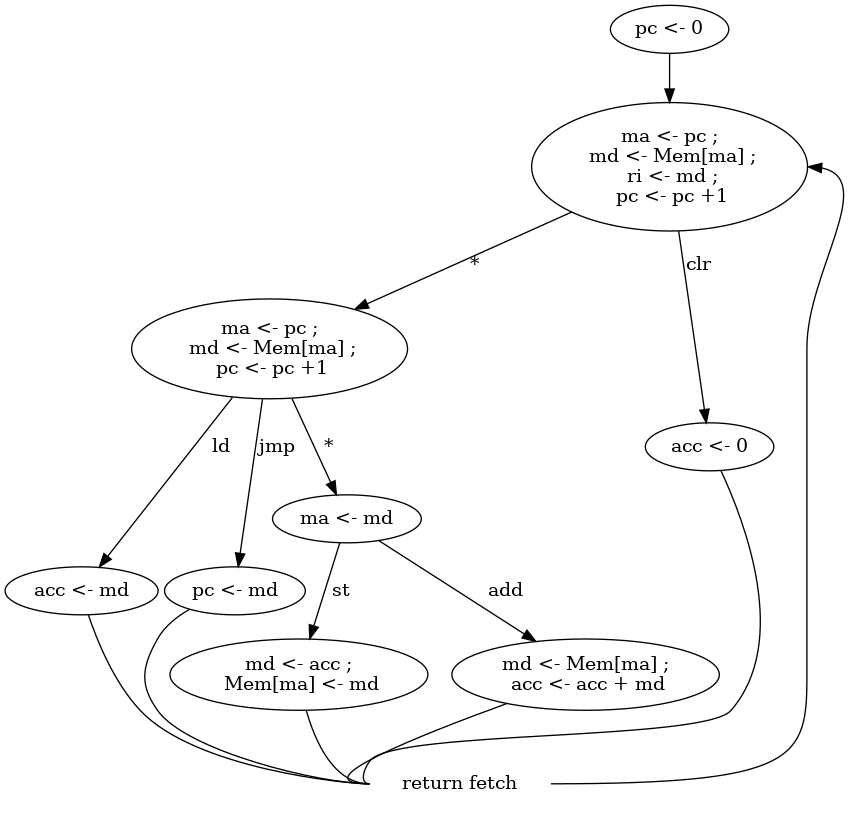

In [22]:
from PIL import Image
from IPython.display import display
!dot -Tpng < graphInit.dot > graphInit.png 
img = Image.open('graphInit.png')
display(img)

In [23]:
%%writefile graphSolution.dot
digraph { 
    init -> fetch;
    fetch -> arg [label = "*"];
    arg -> ld [label = "ld"];
    arg -> jmp [label = "jmp"];
    arg -> tmp  [color="red"];
    arg -> arg2 [label = "*"];
    tmp -> ldd [label ="ldd" ; color="red"];
    tmp -> std [label ="std" ; color="red"];
    arg2 -> st [label = "st"];
    arg2 -> add [label = "add"];
    fetch -> clr [label = "clr"] ;
    {ld clr st add jmp ldd std} -> ret:w  [arrowhead="none"];
    ret -> fetch:e [tailport="e"];
    
    init [label = "..."];     
    fetch [label = "..."];
    clr [label = "..."];
    arg [label = "..."];
    ld [label = "..."];
    jmp [label = "..."];
    arg2 [label = "..."]; 
    st [label = "..."]; 
    add [label = "..."]; 
    ret [label ="..." ; color="white"];
    
    tmp [label ="tmp <- acc + md" ; color="red"];
    ldd [label ="ma <- tmp ;\n md <- Mem[ma] ;\n acc <- md" ; color="red"];
    std [label ="ma <- pc ;\n md <- Mem[ma] ;\n pc <- pc+1 ;\n ma <- tmp ;\n Mem[ma] <- md" ; color="red"];
}

Overwriting graphSolution.dot


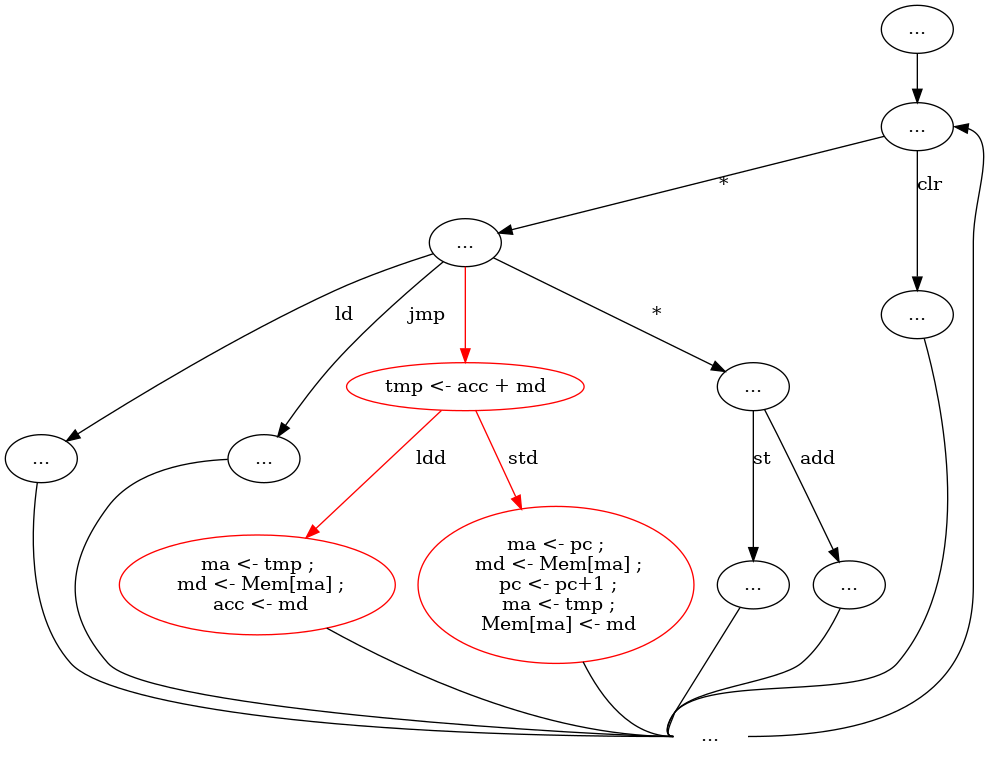

In [24]:
from PIL import Image
from IPython.display import display
!dot -Tpng < graphSolution.dot > graphSolution.png 
img = Image.open('graphSolution.png')
display(img)

<a id="Annexe5"></a>

### Annexe 5 [&uarr;](#RetourAnnexe5)

Le corps de la fonction en entier (variations sur le thème de la question h, l.9, rédigée/testée en 20 min):

In [25]:
%%writefile corpsFonction.s
@si (a[0]+b[0]) == 0 alors loc = 0 sinon l.2 finsi(l.11)  @ Qestion g)
    ldr R0, [fp,#16]
    ldrb R0, [R0]
    ldr R1, [fp,#12]
    ldrb R1, [R1]
    add R0, R0, R1
    cmp R0, #0
    bne l.2
    str R0, [fp,#-4]
    b l.11
l.2: @sinon si a[0] == 0 alors loc = 1 + DistLev(a, adresse de b[1])
    ldr R0, [fp,#16]
    ldrb R0, [R0]
    cmp R0, #0         
    bne l.3
    ldr R0, [fp,#16]
    push {R0}
    ldr R0, [fp,#12]
    add R0,R0,#1 
    push {R0}
    sub SP, SP, #4
    bl DistLev
    pop {R0}
    add SP, SP, #8
    add R0,R0,#1
    str R0, [fp,#-4]         
    b l.11
l.3: @sinon si b[0] == 0 alors loc = 1 + DistLev(adresse de a[1],b)          
    ldr R0, [fp,#12]
    ldrb R0, [R0]
    cmp R0, #0         
    bne l.4
    ldr R0, [fp,#16]
    add R0,R0,#1 
    push {R0}
    ldr R0, [fp,#12]
    push {R0}
    sub SP, SP, #4
    bl DistLev
    pop {R0}
    add SP, SP, #8
    add R0,R0,#1
    str R0, [fp,#-4]         
    b l.11                                             
l.4: @sinon si a[0] == b[0] alors loc = DistLev(adresse de a[1], adresse de b[1])
    ldr R0, [fp,#12]
#ifndef BugTailleB
    ldrb R0, [R0]
#else
    ldr R0, [R0]   @erreur de taille (ldr au lieu de ldrb)
#endif
    ldr R1, [fp,#16]
#ifndef BugTailleB
    ldrb R1, [R1]
#else
    ldr R1, [R1]   @erreur de taille (ldr au lieu de ldrb)
#endif
    cmp R0, R1         
    bne l.5
    ldr R0, [fp,#16]
#ifndef BugTaille4
    add R0,R0,#1 
#else
    add R0,R0,#4 
#endif
    push {R0}
    ldr R0, [fp,#12]
#ifndef BugTaille4
    add R0,R0,#1 
#else
    add R0,R0,#4 
#endif
    push {R0}
    sub SP, SP, #4
    bl DistLev
    pop {R0}
    add SP, SP, #8
    str R0, [fp,#-4]
    b l.11  
l.5: @sinon
l.6:  @loc = 1 + DistLev(adresse de a[1], b)
    ldr R0, [fp,#16]
    add R0,R0,#1 
    push {R0}
    ldr R0, [fp,#12]
    push {R0}
    sub SP, SP, #4
    bl DistLev
    pop {R0}
    add SP, SP, #8
    add R0,R0,#1
    str R0, [fp,#-4]         
l.7: @ alt = 1 + DistLev(adresse de a[1], adresse de b[1])
    ldr R0, [fp,#16]
    add R0,R0,#1 
    push {R0}
    ldr R0, [fp,#12]
    add R0,R0,#1 
    push {R0}
    sub SP, SP, #4
    bl DistLev
    pop {R0}
    add SP, SP, #8
    add R0,R0,#1
    str R0, [fp,#-8]                      
l.8: @si alt < loc alors loc = alt finsi
    ldr R0, [fp,#-8]                      
    ldr R1, [fp,#-4]                      
    cmp R0, R1
    bgt l.9
    str R0,  [fp,#-4]                      
l.9: @alt = 1 + DistLev(a, adresse de b[1])
#ifdef ALT
#include "alt.s"
#endif                                   
l.10: @si alt < loc alors loc = alt finsi
    ldr R0, [fp,#-8]                      
    ldr R1, [fp,#-4]                      
    cmp R0, R1
    bgt l.11
    str R0,  [fp,#-4]                          
l.11: nop

Overwriting corpsFonction.s


Quelques tests pour vérifier que cela marche :

In [26]:
!cpp  -D APPEL -D FONCTION -D CORPS -D ALT progTBC.s > prog.s
!arm-linux-gnueabi-gcc -static prog.s es.s -o prog.e
!printf "\n\n" | qemu-arm  prog.e

Entrer un mot
Entrer un mot
Distance entre les 2 mots 
0


In [27]:
!cpp  -D APPEL -D FONCTION -D CORPS -D ALT progTBC.s > prog.s
!arm-linux-gnueabi-gcc -static prog.s es.s -o prog.e
!printf "INM\n\n" | qemu-arm  prog.e

Entrer un mot
Entrer un mot
Distance entre les 2 mots 
3


In [28]:
!cpp  -D APPEL -D FONCTION -D CORPS -D ALT progTBC.s > prog.s
!arm-linux-gnueabi-gcc -static prog.s es.s -o prog.e
!printf "\nMIN\n" | qemu-arm  prog.e

Entrer un mot
Entrer un mot
Distance entre les 2 mots 
3


In [29]:
!cpp  -D APPEL -D FONCTION -D CORPS -D ALT progTBC.s > prog.s
!arm-linux-gnueabi-gcc -static prog.s es.s -o prog.e
!printf "INM\nMIN\n" | qemu-arm  prog.e

Entrer un mot
Entrer un mot
Distance entre les 2 mots 
2


In [30]:
!cpp  -D APPEL -D FONCTION -D CORPS -D ALT progTBC.s > prog.s
!arm-linux-gnueabi-gcc -static prog.s es.s -o prog.e
!printf "INM\nINM\n" | qemu-arm  prog.e

Entrer un mot
Entrer un mot
Distance entre les 2 mots 
0


Tout semble ok.

<a id="Annexe6"></a>

### Annexe 6 [&uarr;](#RetourAnnexe6)

L'ensemble du programme en assembleur :

In [31]:
!cpp  -P -D APPEL -D FONCTION -D CORPS -D ALT progTBC.s

.data
msg1: .asciz "Entrer un mot"
msg2: .asciz "Distance entre les 2 mots "
d: .word 42
.bss
ch1: .skip 80
ch2: .skip 80
.text
.global main
main: push {lr}
    @@ A COMPLETER
@20: EcrChaine("Entrer un mot")
    ldr R1, LD_msg1 @ Qestion d)
    bl EcrChaine @ Qestion d)
@21: LireChaine(&ch1)
    ldr R1, LD_ch1 @ Qestion d)
    bl LireChaine @ Qestion d)
   
@22: EcrChaine("Entrer un mot")
    ldr R1, LD_msg1
    bl EcrChaine
@23: LireChaine(&ch2)
    ldr R1, LD_ch2
    bl LireChaine
   
@24: d:=DistLev(ch1,ch2)
@d:=DistLev(ch1,ch2)
    ldr R0, LD_ch1
    push {R0}
    ldr R0, LD_ch2
    push {R0}
    mov R0, #1024
    push {R0}
    bl DistLev
    pop {R0}
    add SP, SP, #8
    ldr R1, LD_d
    str R0, [R1]
@25: EcrChaine("Distance entre les 2 mots ")
    ldr R1, LD_msg2 @ Qestion d)
    bl EcrChaine @ Qestion d)
@26: EcrNdecimal32(d)
    ldr R1, LD_d @ Qestion d)
    ldr R1, [R1] @ Qestion d)
    bl EcrNdecimal32 @ Qestion d)
    pop {lr}
    mov R0, #0
    bx lr
DistLev:
    push {lr

<a id="Annexe7"></a>

### Annexe 7 [&uarr;](#RetourAnnexe7)

Une erreur de saisie courante  :  

* après la lecture d'une chaîne, la chaîne est déjà stockée à l'adresse fournie pour la lecture, 
* il n'y a pas besoin de faire une écriture
* pourtant on voit des str ...
```
    ldr R1, LD_ch1 
    bl LireChaine
    str R0, [R1]
```

Si on affiche la chaîne lue, voilà le résultat :

In [39]:
!cpp -D APPEL -D FONCTION -D CORPS -D ALT  -D '_CONTROLE_CH1=£str R0, [R1]£ldr R1, LD_ch1£bl EcrChaine£' -D '_CONTROLE_CH2=£ldr R1, LD_ch2£bl EcrChaine£' progTBC.s | tr '£' '\n' > prog.s
!arm-linux-gnueabi-gcc -static prog.s es.s -o prog.e
!printf 'INM\nMIN\n' | qemu-arm  prog.e

Entrer un mot

Entrer un mot
MIN
Distance entre les 2 mots 
3


La chaîne semble avoir disparue ! (à l'affichage, et dans le calcul)

Et oui, ```str R0, [R1]``` écrit ```R0``` à l'adresse ```R1```. Or ```R0``` c'est le résultat du dernier appel de la fonction de saisie, c'est le nombre de résultats lus et ```R1``` c'est l'adresse de la chaîne qui vient d'être lue. Donc cette ligne mets un ```0``` ou ```1``` en début de chaîne ! Si c'est ```0```, c'est comme si on effaçait la chaîne, si c'est ```1``` ce n'est pas mieux (caractère non affichable) !

<a id="Annexe8"></a>

### Annexe 8 [&uarr;](#RetourAnnexe8)

Des erreurs de taille :  

* les lettres sont des octets (bytes), pour le lire, il ne faut pas oublier de le préciser et utiliser ```ldrb R0,[R0]``` au lieu de ```ldr R0,[R0]```
* sinon, ce sont 4 lettres qui sont prises en même temps (et les chances que les 4 soient identiques ne sont pas les même que si la première lettre seulement avait été prise)
* si on essaye ce que cela donne :

In [33]:
!cpp  -D APPEL -D FONCTION -D CORPS -D ALT -D BugTailleB progTBC.s > prog.s
!arm-linux-gnueabi-gcc -static prog.s es.s -o prog.e
!printf "INM2\nINM3\n" | qemu-arm  prog.e

Entrer un mot
Entrer un mot
Distance entre les 2 mots 
4


Entre ```INM2```et ```INM3``` la distance devrait être de 1, mais le résultat est 4, parce que ce n'est pas ```I``` qui est comparé à ```I```, mais ```INM2``` qui est comparé à ```INM3```

Autre erreur de lecture (cohérente avec ce qui précède, mais malheureusement fausse aussi, c'est cohérent) :  

* Les adresses de la lettre d'indice ```K``` (dans ```R1```), sont ```R0 + R1``` (avec ```R0``` adresse de base) et non pas ```R0 + R1 LSL #2```. Avec cette définition, c'est l'adresse d'une lettre  4 fois trop loin, et 3 lettres sont sautées.

In [34]:
!cpp  -D APPEL -D FONCTION -D CORPS -D ALT -D BugTaille4 progTBC.s > prog.s
!arm-linux-gnueabi-gcc -static prog.s es.s -o prog.e
!printf "INM2\nINM3\n" | qemu-arm  prog.e

Entrer un mot
Entrer un mot
Distance entre les 2 mots 
0


Entre ```INM2```et ```INM3``` la distance devrait toujours être de 1, mais le résultat est 0, parce que une fois ```I``` comparé à ```I```, le programme avance de 3 lettres, et c'est déjà la fin des chaînes, donc tous les tests ont été concluants, la distance est de 0.

Pour comparer le 2 et le 3, il faudrait qu'ils soient une place plus loin (en 4e position), et les lettres entre le I et le 2 ou le 3 pourraient être n'importe quoi, ce qui donnerait :

In [35]:
!cpp  -D APPEL -D FONCTION -D CORPS -D ALT -D BugTaille4 progTBC.s > prog.s
!arm-linux-gnueabi-gcc -static prog.s es.s -o prog.e
!printf "IXYZ2\nIABC3\n" | qemu-arm  prog.e

Entrer un mot
Entrer un mot
Distance entre les 2 mots 
1


C'est le bon résultat pour comparer ```I2``` et ```I3```, mais pas pour ```Ixyz2``` et ```Iabc3```.

### Annexe 99

Pour éliminer les fichiers inutiles, mettre ```true``` au lieu de ```false``` dans la commande suivante

In [36]:
!if false; then rm alt.s appel.s corpsMain.s corpsFonction.s fonction.s progTBC.s prog.e *.dot *.r; fi;